## Prediccion de demanda semanal

In [63]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import lightgbm as lgb

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error

import json

import optuna

In [64]:
df = pd.read_csv('../data_clean/data_modelado.csv')
df[["Fecha", "Region", "ID_Region", "Cantidad_Semanal"]]

,Fecha,Region,ID_Region,Cantidad_Semanal
0,2024-02-05,Buenos Aires,0,43
1,2024-02-08,Buenos Aires,0,43
2,2024-02-11,Buenos Aires,0,43
3,2024-02-11,Buenos Aires,0,43
4,2024-02-11,Buenos Aires,0,43
...,...,...,...,...
2134,2024-12-03,Patagonia,5,29
2135,2024-12-12,Patagonia,5,19
2136,2024-12-16,Patagonia,5,21
2137,2024-12-21,Patagonia,5,21


In [65]:
# Time Series Split
tscv = TimeSeriesSplit(n_splits=5)

# Mantenemos solamente las columnas numericas
df_numeric = df.select_dtypes(include=[np.number])

# LGBM usa todas las regiones menos NEA y NOA
df_lgbm = df_numeric[~df_numeric['ID_Region'].isin([3, 4])]

X_lgbm = df_lgbm.drop(columns=['Cantidad', 'Cantidad_Semanal', 'Monto_Venta'])
y_lgbm = df_lgbm['Cantidad_Semanal']


# Media movil para NEA y NOA
df_ma = df[df['ID_Region'].isin([3, 4])]

X_ma = df_ma.drop(columns=['Cantidad', 'Cantidad_Semanal', 'Monto_Venta'])
y_ma = df_ma['Cantidad_Semanal']

In [66]:
# Hyperparameter tuning con Optuna para LGBM con TSCV
def objective(trial):
    params = {
        'objective': 'regression',
        'metric': 'rmse',
        'boosting_type': 'gbdt',
        'verbosity': -1,  # Suppress warnings
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 20, 256),  # Reduced max
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 5, 50),  # Adjusted range
        'feature_fraction': trial.suggest_float('feature_fraction', 0.6, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.6, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'seed': 42,
    }
    
    rmse_scores = []

    for fold, (train_index, val_index) in enumerate(tscv.split(X_lgbm)):
        X_train, X_val = X_lgbm.iloc[train_index], X_lgbm.iloc[val_index]
        y_train, y_val = y_lgbm.iloc[train_index], y_lgbm.iloc[val_index]

        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_val = lgb.Dataset(X_val, y_val, reference=lgb_train)
        
        gbm = lgb.train(
            params,
            lgb_train,
            num_boost_round=1000,
            valid_sets=[lgb_val],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(period=0)
            ]
        )
        
        y_pred = gbm.predict(X_val, num_iteration=gbm.best_iteration)
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
        
        # Report for pruning
        trial.report(rmse, fold)
        if trial.should_prune():
            raise optuna.TrialPruned()
        
        rmse_scores.append(rmse)
    
    return float(np.mean(rmse_scores))

In [67]:
# Optimización de hiperparámetros con Optuna

# If no json
try:
    with open('best_lgbm_params.json', 'r') as f:
        best_params = json.load(f)
except FileNotFoundError:
    optuna.logging.set_verbosity(optuna.logging.WARNING)

    sampler = optuna.samplers.TPESampler(seed=42)
    pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=0)

    study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)

    # Quitar comentario para optimizar de nuevo
    study.optimize(objective, n_trials=50, show_progress_bar=True)

    print("Mejores hiperparámetros: ", study.best_params)
    print("Mejor RMSE: ", study.best_value)

    # Save best params
    best_params = study.best_params
    with open('best_lgbm_params.json', 'w') as f:
        json.dump(best_params, f)

Best trial: 17. Best value: 11.3527: 100%|██████████| 50/50 [01:35<00:00,  1.90s/it]

Mejores hiperparámetros:  {'learning_rate': 0.020655958307775498, 'num_leaves': 123, 'max_depth': 11, 'min_data_in_leaf': 10, 'feature_fraction': 0.7390907986673838, 'bagging_fraction': 0.8604035330355403, 'bagging_freq': 6, 'lambda_l1': 0.05998558505792558, 'lambda_l2': 1.4534088606555146e-05}
Mejor RMSE:  11.352652577831817


In [68]:
# Agregamos al df columnas Modelo_Usado y Cantidad_Predicha
df['Modelo_Usado'] = np.where(df['ID_Region'].isin([3, 4]), 'Media_Movil', 'LGBM')

# Inicializamos la columna de predicciones con NaN
df['Cantidad_Predicha'] = np.nan

# Hacemos las predicciones con LGBM
best_params = study.best_params
best_params['objective'] = 'regression'
best_params['metric'] = 'rmse'
best_params['boosting_type'] = 'gbdt'
best_params['verbosity'] = -1  # Suppress warnings
best_params['seed'] = 42

# Usamos TimeSeriesSplit para predicciones out-of-sample
# El primer fold de entrenamiento no tendrá predicciones
for fold, (train_index, val_index) in enumerate(tscv.split(X_lgbm)):
    X_train = X_lgbm.iloc[train_index]
    y_train = y_lgbm.iloc[train_index]
    X_val = X_lgbm.iloc[val_index]
    
    lgb_train = lgb.Dataset(X_train, y_train)
    lgbm_model = lgb.train(
        best_params,
        lgb_train,
        num_boost_round=1000
    )
    
    # Obtenemos los índices originales del DataFrame para asignar predicciones
    original_indices = X_lgbm.iloc[val_index].index
    predictions = lgbm_model.predict(X_val, num_iteration=lgbm_model.best_iteration)
    df.loc[original_indices, 'Cantidad_Predicha'] = predictions

print(f"Predicciones LGBM generadas para {df[df['Modelo_Usado'] == 'LGBM']['Cantidad_Predicha'].notna().sum()} de {len(df[df['Modelo_Usado'] == 'LGBM'])} filas")
print(f"Primeras {df[df['Modelo_Usado'] == 'LGBM']['Cantidad_Predicha'].isna().sum()} filas (primer fold de entrenamiento) tienen NaN")

Predicciones LGBM generadas para 1530 de 1839 filas
Primeras 309 filas (primer fold de entrenamiento) tienen NaN


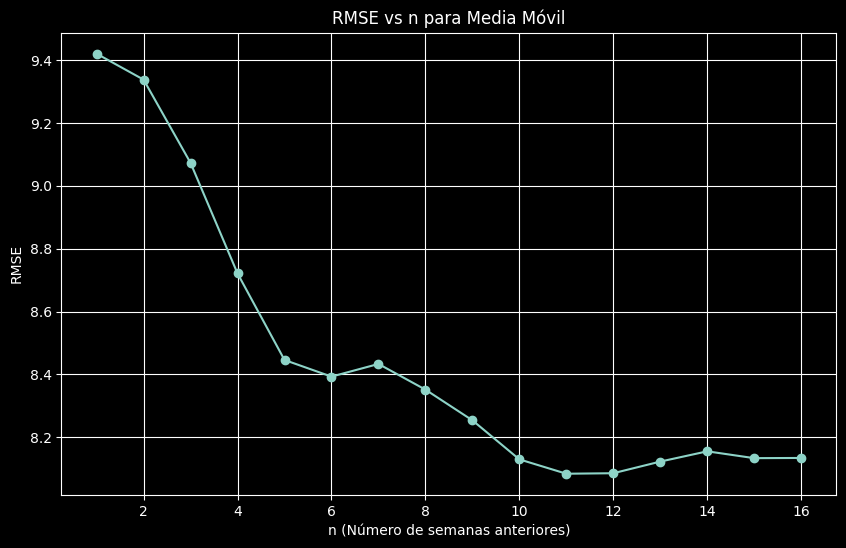

Mejor n para media movil: 11


In [69]:
# n optima para media movil en NEA y NOA

# Las ventas semanales en la region seran el promeido de las n semanas anteriores

n=range(1,17)

def evaluate_ma(n):
    MAs = []

    # Empezamos en la semana n por region
    idx = df_ma[df_ma['semana'] == n].index

    # Calculamos la media movil para cada region
    MAs = df_ma.groupby('ID_Region')['Cantidad_Semanal'].transform(lambda x: x.shift(1).rolling(window=n, min_periods=1).mean())

    # Evaluación del modelo de media movil
    rmse_list = []
    for fold, (train_index, val_index) in enumerate(tscv.split(df_ma)):
        y_val = df_ma.iloc[val_index]['Cantidad_Semanal']
        y_pred = MAs.iloc[val_index]
        rmse = np.sqrt(np.mean((y_val - y_pred) ** 2))
        rmse_list.append(rmse)
    
    return {'n': n, 'RMSE': float(np.mean(rmse_list))}


ma_results = [evaluate_ma(i) for i in n]
ma_results_df = pd.DataFrame(ma_results)
best_n = ma_results_df.loc[ma_results_df['RMSE'].idxmin(), 'n']

# Plot RMSE vs n
plt.figure(figsize=(10, 6))
plt.plot(ma_results_df['n'], ma_results_df['RMSE'], marker='o')
plt.title('RMSE vs n para Media Móvil')
plt.xlabel('n (Número de semanas anteriores)')
plt.ylabel('RMSE')
plt.grid()
plt.show()

print(f"Mejor n para media movil: {best_n}")


In [70]:
# Agregamos las predicciones de media movil al df
df_ma['Pred_MA'] = df_ma.groupby('ID_Region')['Cantidad_Semanal'].transform(lambda x: x.shift(1).rolling(window=best_n, min_periods=1).mean())
df.loc[df['Modelo_Usado'] == 'Media_Movil', 'Cantidad_Predicha'] = df_ma['Pred_MA']

/tmp/ipykernel_82276/1865736161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ma['Pred_MA'] = df_ma.groupby('ID_Region')['Cantidad_Semanal'].transform(lambda x: x.shift(1).rolling(window=best_n, min_periods=1).mean())


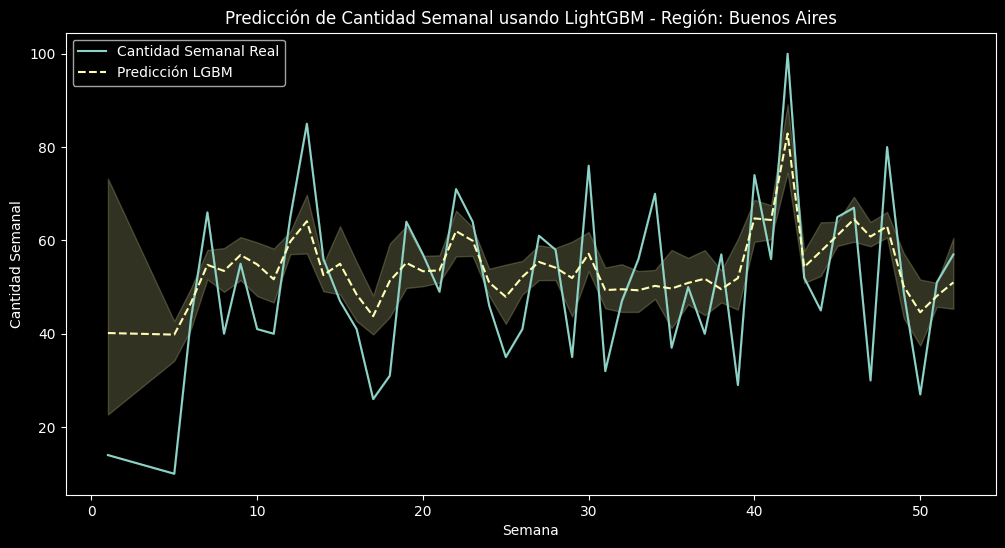

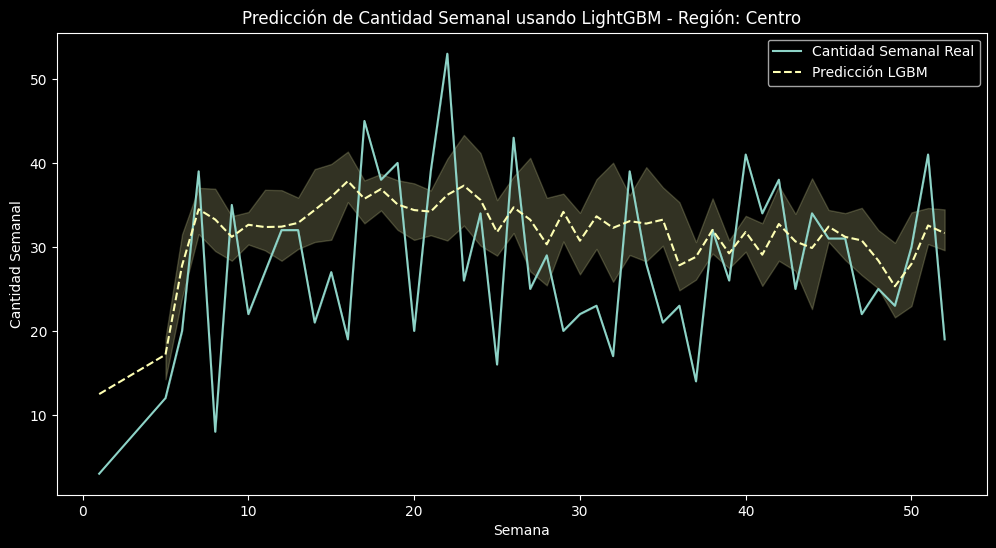

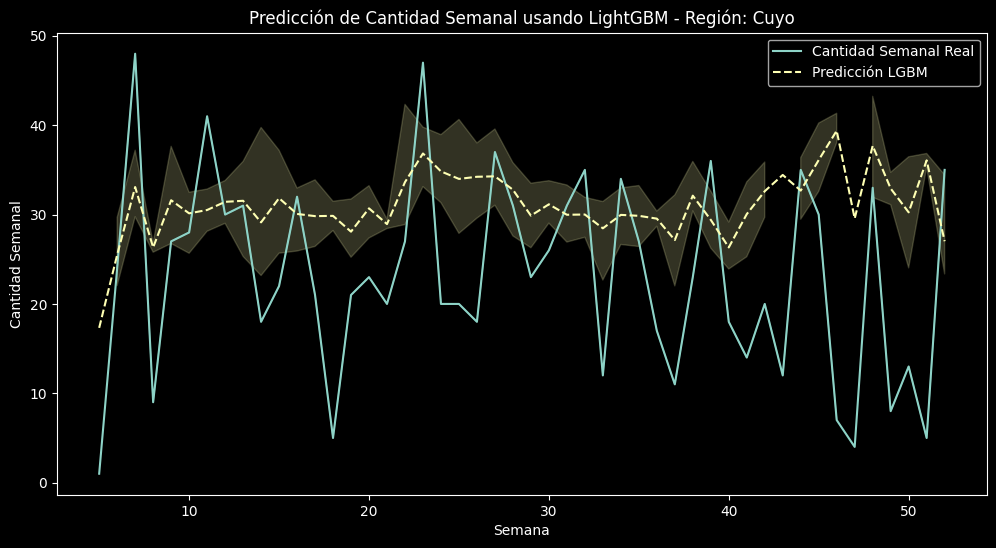

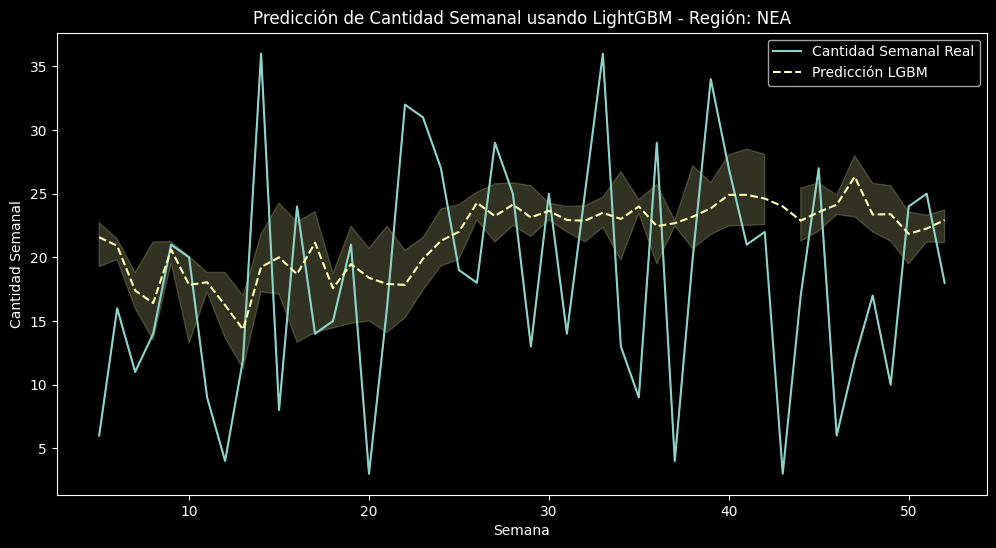

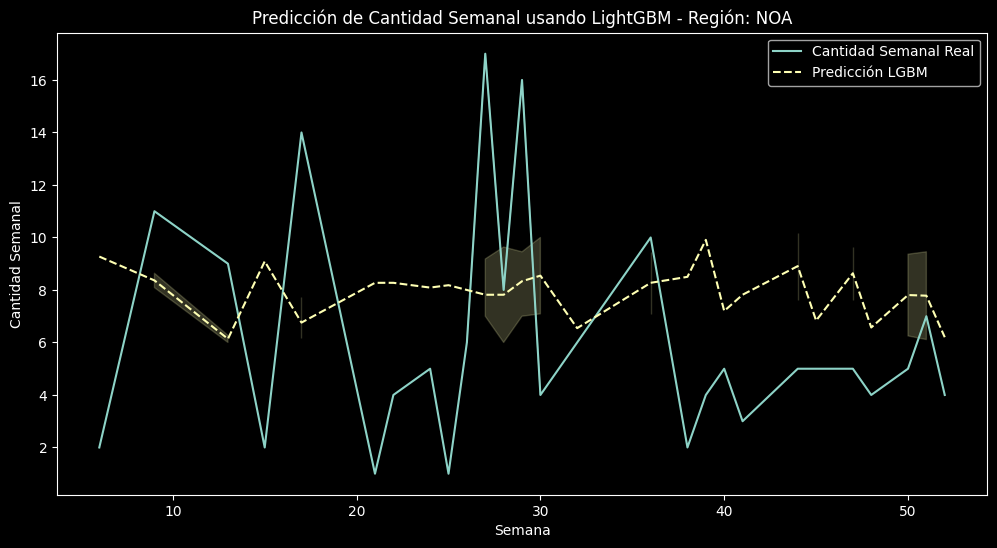

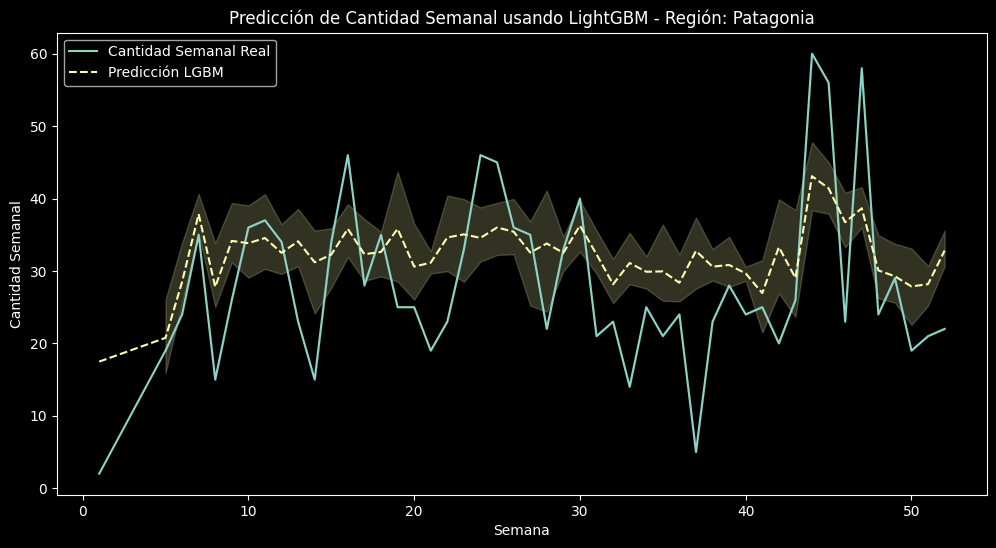

In [71]:
# Plots por región
for region in df['Region'].unique():
    plt.figure(figsize=(12, 6))
    region_data = df[df['Region'] == region]
    sns.lineplot(data=region_data, x='semana', y='Cantidad_Semanal', errorbar=("ci", 100), label='Cantidad Semanal Real')
    sns.lineplot(data=region_data, x='semana', y='Cantidad_Predicha', errorbar=("ci", 100), label='Predicción LGBM', linestyle='--')
    plt.title(f'Predicción de Cantidad Semanal usando LightGBM - Región: {region}')
    plt.xlabel('Semana')
    plt.ylabel('Cantidad Semanal')
    plt.legend()
    plt.show()

In [72]:
# Guardamos el df final con fecha, region, categoria, cantidad semanal y cantidad predicha
df_pred = df[['Fecha', 'Region', 'Categoria', 'Cantidad_Semanal', 'Cantidad_Predicha']]
df_pred.to_csv('../data_clean/data_con_predicciones.csv', index=False)